In [1]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

# Fun with Neural Nets

---

Below is a procedure for building a neural network to recognize handwritten digits.  The data is from Kaggle, and you will submit your results to Kaggle to test how well you did!

1. Load the training data (`train.csv`) from Kaggle
2. Setup X and y (feature matrix and target vector)
3. Split X and y into train and test subsets.
4. Preprocess your data

   - When dealing with image data, you need to normalize your `X` by dividing each value by the max value of a pixel (255).
   - Since this is a multiclass classification problem, keras needs `y` to be a one-hot encoded matrix
   
5. Create your network.

   - Remember that for multi-class classification you need a softamx activation function on the output layer.
   - You may want to consider using regularization or dropout to improve performance.
   
6. Trian your network.
7. If you are unhappy with your model performance, try to tighten up your model by adding hidden layers, adding hidden layer units, chaning the activation functions on the hidden layers, etc.
8. Load in Kaggle's `test.csv`
9. Create your predictions (these should be numbers in the range 0-9).
10. Save your predictions and submit them to Kaggle.

---

For this lab, you should complete the above sequence of steps for _at least_ two of the three "configurations":

1. Using a `tensorflow` network
2. Using a `keras` "sequential" network
3. Using a `keras` convolutional network
4. Using a `tensorflow` convolutional network (we did _not_ cover this in class!)

In [1]:
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import to_categorical
from keras import regularizers
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Using TensorFlow backend.


In [2]:
data_train = pd.read_csv('./train.csv')

In [3]:
data_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
y = data_train['label']
X = data_train.drop('label', axis=1).values

In [7]:
y = pd.get_dummies(y).values

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

X_train = X_train/255
X_test = X_test/255

In [8]:
X_train.shape

(31500, 784)

## Tensorflow Model 

In [17]:
# Tensorflow

# creating the graph
tf.reset_default_graph()


# Making placeholders
X = tf.placeholder(dtype=tf.float32,
                   shape=(None,X_train.shape[1]),
                   name='X')
y = tf.placeholder(dtype=tf.float32,
                   shape=(None),
                   name='y')


# Defining our network topology
n_hidden = X_train.shape[1]
hidden1 = tf.layers.dense(X, units=n_hidden,
                          name='hidden1',
                          activation=tf.nn.softmax)
y_preds = tf.layers.dense(hidden1, units=y_train.shape[1],
                          name='y_preds',
                          activation=None)


# setting up back propogation
loss = tf.losses.softmax_cross_entropy(y, y_preds)

learning_rate = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate)

training_op = optimizer.minimize(loss)

saver = tf.train.Saver()

In [34]:
%%time
init = tf.global_variables_initializer()

train_err = []
test_err = []

with tf.Session() as sess:
    init.run()
    
    for epoch in range(300):
        sess.run(training_op,
                 feed_dict={X:X_train, y:y_train})
        train_loss = sess.run(loss,
                             feed_dict={X:X_train, y:y_train})
        test_loss = sess.run(loss,
                             feed_dict={X:X_test, y:y_test})
        train_err.append(train_loss)
        test_err.append(test_loss)
        if epoch % 25 == 0:
            print('epoch', epoch, train_loss,test_loss)
    
    
    saver.save(sess, './digits.ckpt')
    
    # Getting your predicted target values
    pred = sess.run(y_preds,
                    feed_dict={X:X_test})


epoch 0 2.2940106 2.2937915
epoch 25 1.8612969 1.8615954
epoch 50 1.3572947 1.3702422
epoch 75 0.94496924 0.9768906
epoch 100 0.6649768 0.7171733
epoch 125 0.47920057 0.5502905
epoch 150 0.36206034 0.4520405
epoch 175 0.28707644 0.39449325
epoch 200 0.2361004 0.35876292
epoch 225 0.1996549 0.33638257
epoch 250 0.17249228 0.32165936
epoch 275 0.15190327 0.3121612
CPU times: user 1h 50min 38s, sys: 1min 18s, total: 1h 51min 56s
Wall time: 16min 15s


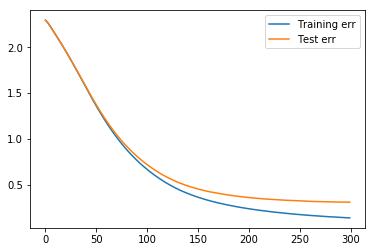

In [35]:
# Plot the learning curves
plt.plot(train_err, label='Training err')
plt.plot(test_err, label='Test err')
plt.legend()

In [48]:
pred_list = []
for each in pred:
     pred_list.append(np.argmax(each))

In [44]:
true_list = []
for each in y_test:
    true_list.append(np.argmax(each))

In [58]:
true_list = pd.Series(true_list, name='Actual')
pred_list = pd.Series(pred_list, name='Predicted')
tf_confusion = pd.crosstab(true_list, pred_list)

In [60]:
tf_confusion

Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,1000,0,7,0,3,2,7,1,2,3
1,0,1121,7,2,1,4,0,2,8,1
2,6,8,988,18,14,6,5,8,17,2
3,2,3,19,1055,1,28,1,8,19,15
4,4,1,10,1,958,2,13,2,2,31
5,3,1,5,28,5,833,7,2,11,3
6,6,2,15,1,5,9,966,0,6,0
7,2,3,13,6,11,1,0,1077,2,20
8,4,11,12,23,5,16,2,4,922,6


## Keras Model 1

In [9]:
# Setting up our data and using keras to_categorical to get dummy variables for all y classes
y = data_train['label'].values
X = data_train.drop('label', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

X_train = X_train/255
X_test = X_test/255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [10]:
model_1 = Sequential()

n_input = X_train.shape[1]
n_hidden = n_input
n_output = y_train.shape[1]

model_1.add(Dense(n_hidden,
                input_dim= n_input,
                activation= 'relu'))
model_1.add(Dense(n_output,
                activation='softmax'))

In [11]:
model_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [69]:
hist_1 = model_1.fit(X_train,y_train,
                 validation_data=(X_test,y_test),
                 epochs=100,
                 verbose=0)

In [75]:
hist_1.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

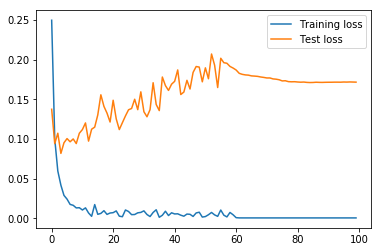

In [70]:
plt.plot(hist_1.history['loss'], label='Training loss')
plt.plot(hist_1.history['val_loss'], label='Test loss')
plt.legend()

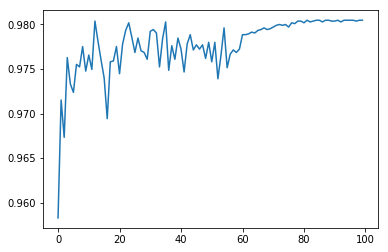

In [71]:
plt.plot(hist_1.history['val_acc'])

In [79]:
pred_list = model_1.predict_classes(X_test)

In [86]:
actual_list = []
for each in y_test:
    actual_list.append(np.argmax(each))

In [90]:
actual_list = pd.Series(actual_list, name='Actual')
pred_list = pd.Series(pred_list, name='Predicted')
keras_confusion = pd.crosstab(actual_list, pred_list)

Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,1015,0,3,1,0,3,1,1,0,1
1,0,1140,2,1,1,0,0,0,2,0
2,1,8,1047,5,5,0,0,1,3,2
3,1,1,1,1124,0,8,0,4,6,6
4,3,0,2,0,999,1,7,2,0,10
5,0,1,0,9,0,874,6,2,3,3
6,5,3,1,0,0,4,993,1,3,0
7,0,4,5,2,3,1,0,1114,0,6
8,0,5,4,4,1,6,4,2,978,1


## Keras Model 2 with L2 Regularization

In [ ]:
# Setting up our data and using keras to_categorical to get dummy variables for all y classes
y = data_train['label'].values
X = data_train.drop('label', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

X_train = X_train/255
X_test = X_test/255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [22]:
model_2 = Sequential()

n_input = X_train.shape[1]
n_hidden = n_input
n_output = y_train.shape[1]

model_2.add(Dense(n_hidden,
                  input_dim= n_input,
                  activation='relu',
                  kernel_regularizer= regularizers.l2(0.01)))
model_2.add(Dense(n_output,
                  activation='softmax',
                  kernel_regularizer=regularizers.l2(0.01)))
model_2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [23]:
hist_2 = model_2.fit(X_train,y_train,
                     validation_data=(X_test,y_test),
                     epochs=100,
                     verbose=1)

Train on 31500 samples, validate on 10500 samples
Epoch 1/100
31500/31500 [==============================] - 13s 407us/step - loss: 1.1090 - acc: 0.8744 - val_loss: 0.8090 - val_acc: 0.8714
Epoch 2/100
31500/31500 [==============================] - 12s 366us/step - loss: 0.7834 - acc: 0.8897 - val_loss: 0.7985 - val_acc: 0.8770
Epoch 3/100
31500/31500 [==============================] - 12s 369us/step - loss: 0.7684 - acc: 0.8915 - val_loss: 0.7869 - val_acc: 0.8850
Epoch 4/100
31500/31500 [==============================] - 12s 383us/step - loss: 0.7588 - acc: 0.8945 - val_loss: 0.7525 - val_acc: 0.8912
Epoch 5/100
31500/31500 [==============================] - 12s 374us/step - loss: 0.7510 - acc: 0.8978 - val_loss: 0.7719 - val_acc: 0.8837
Epoch 6/100
31500/31500 [==============================] - 11s 363us/step - loss: 0.7430 - acc: 0.8992 - val_loss: 0.7403 - val_acc: 0.8966
Epoch 7/100
31500/31500 [==============================] - 12s 377us/step - loss: 0.7363 - acc: 0.9025 - val_l

Epoch 59/100
31500/31500 [==============================] - 12s 386us/step - loss: 0.6992 - acc: 0.9082 - val_loss: 0.7106 - val_acc: 0.9082
Epoch 60/100
31500/31500 [==============================] - 12s 376us/step - loss: 0.6992 - acc: 0.9097 - val_loss: 0.7110 - val_acc: 0.9050
Epoch 61/100
31500/31500 [==============================] - 12s 372us/step - loss: 0.6995 - acc: 0.9095 - val_loss: 0.6999 - val_acc: 0.9075
Epoch 62/100
31500/31500 [==============================] - 12s 371us/step - loss: 0.7001 - acc: 0.9089 - val_loss: 0.6977 - val_acc: 0.9108
Epoch 63/100
31500/31500 [==============================] - 12s 374us/step - loss: 0.7005 - acc: 0.9078 - val_loss: 0.7020 - val_acc: 0.9079
Epoch 64/100
31500/31500 [==============================] - 12s 380us/step - loss: 0.7005 - acc: 0.9094 - val_loss: 0.7009 - val_acc: 0.9053
Epoch 65/100
31500/31500 [==============================] - 12s 377us/step - loss: 0.6994 - acc: 0.9082 - val_loss: 0.7033 - val_acc: 0.9063
Epoch 66/100


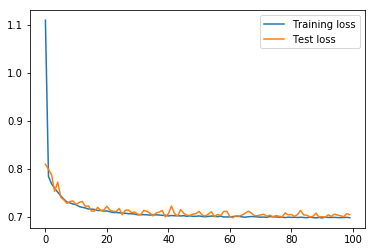

In [24]:
plt.plot(hist_2.history['loss'], label='Training loss')
plt.plot(hist_2.history['val_loss'], label='Test loss')
plt.legend()

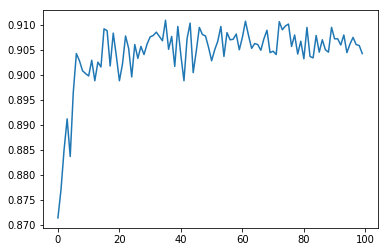

In [29]:
plt.plot(hist_2.history['val_acc'])

In [31]:
hist_2.history['val_acc'][-1]

0.9042857142857142

In [25]:
pred_list = model_2.predict_classes(X_test)

In [26]:
actual_list = []
for each in y_test:
    actual_list.append(np.argmax(each))

In [28]:
actual_list = pd.Series(actual_list, name='Actual')
pred_list = pd.Series(pred_list, name='Predicted')
keras2_confusion = pd.crosstab(actual_list, pred_list)
keras2_confusion

Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,995,0,2,0,2,6,9,0,8,3
1,0,1128,2,1,1,3,3,2,5,1
2,11,19,928,13,27,1,26,22,22,3
3,5,12,36,956,1,46,11,20,27,37
4,2,5,7,0,896,0,22,2,1,89
5,13,13,7,23,15,769,30,5,9,14
6,14,3,10,1,3,5,969,0,5,0
7,2,24,17,3,17,4,0,1031,1,36
8,3,28,5,24,6,17,10,4,887,21


## Keras Model 3 With Dropout(0.2)

In [32]:
# Setting up our data and using keras to_categorical to get dummy variables for all y classes
y = data_train['label'].values
X = data_train.drop('label', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

X_train = X_train/255
X_test = X_test/255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [33]:
model_3 = Sequential()

n_input = X_train.shape[1]
n_hidden = n_input
n_output = y_train.shape[1]

model_3.add(Dense(n_hidden,
                  input_dim= n_input,
                  activation='relu'))
model_3.add(Dropout(.2))

model_3.add(Dense(n_output,
                  activation='softmax'))

model_3.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [35]:
hist_3 = model_3.fit(X_train,y_train,
                     validation_data=(X_test,y_test),
                     epochs= 100,
                     verbose=1)

Train on 31500 samples, validate on 10500 samples
Epoch 1/100
31500/31500 [==============================] - 11s 348us/step - loss: 0.0462 - acc: 0.9849 - val_loss: 0.0850 - val_acc: 0.9756
Epoch 2/100
31500/31500 [==============================] - 11s 347us/step - loss: 0.0381 - acc: 0.9871 - val_loss: 0.0896 - val_acc: 0.9741
Epoch 3/100
31500/31500 [==============================] - 11s 344us/step - loss: 0.0312 - acc: 0.9895 - val_loss: 0.0818 - val_acc: 0.9760
Epoch 4/100
31500/31500 [==============================] - 11s 345us/step - loss: 0.0272 - acc: 0.9912 - val_loss: 0.0811 - val_acc: 0.9771
Epoch 5/100
31500/31500 [==============================] - 11s 349us/step - loss: 0.0225 - acc: 0.9927 - val_loss: 0.1031 - val_acc: 0.9745
Epoch 6/100
31500/31500 [==============================] - 11s 346us/step - loss: 0.0225 - acc: 0.9926 - val_loss: 0.0903 - val_acc: 0.9773
Epoch 7/100
31500/31500 [==============================] - 11s 353us/step - loss: 0.0175 - acc: 0.9942 - val_l

Epoch 59/100
31500/31500 [==============================] - 11s 357us/step - loss: 0.0051 - acc: 0.9987 - val_loss: 0.1853 - val_acc: 0.9782
Epoch 60/100
31500/31500 [==============================] - 12s 372us/step - loss: 0.0089 - acc: 0.9974 - val_loss: 0.1948 - val_acc: 0.9767
Epoch 61/100
31500/31500 [==============================] - 11s 358us/step - loss: 0.0090 - acc: 0.9981 - val_loss: 0.1713 - val_acc: 0.9809
Epoch 62/100
31500/31500 [==============================] - 11s 365us/step - loss: 0.0058 - acc: 0.9986 - val_loss: 0.1697 - val_acc: 0.9799
Epoch 63/100
31500/31500 [==============================] - 12s 374us/step - loss: 0.0078 - acc: 0.9981 - val_loss: 0.1800 - val_acc: 0.9784
Epoch 64/100
31500/31500 [==============================] - 12s 375us/step - loss: 0.0067 - acc: 0.9984 - val_loss: 0.1839 - val_acc: 0.9787
Epoch 65/100
31500/31500 [==============================] - 11s 359us/step - loss: 0.0053 - acc: 0.9982 - val_loss: 0.1799 - val_acc: 0.9782
Epoch 66/100


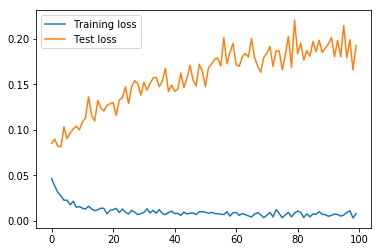

In [36]:
plt.plot(hist_3.history['loss'], label='Training loss')
plt.plot(hist_3.history['val_loss'], label='Test loss')
plt.legend()

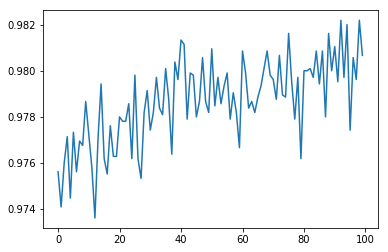

In [37]:
plt.plot(hist_3.history['val_acc'])

In [38]:
hist_3.history['val_acc'][-1]

0.9806666666666667

In [39]:
pred_list= model_3.predict_classes(X_test)

actual_list = []
for each in y_test:
    actual_list.append(np.argmax(each))

In [40]:
actual_list = pd.Series(actual_list, name='Actual')
pred_list = pd.Series(pred_list, name='Predicted')
keras3_confusion = pd.crosstab(actual_list, pred_list)
keras3_confusion

Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,1012,0,2,2,0,2,4,1,0,2
1,0,1140,2,0,1,1,1,1,0,0
2,4,6,1050,4,5,0,1,0,2,0
3,0,0,3,1130,0,7,0,3,6,2
4,3,0,1,0,1001,0,9,3,0,7
5,1,1,0,10,0,877,6,1,0,2
6,5,2,0,0,0,2,1001,0,0,0
7,0,3,7,2,4,3,0,1115,0,1
8,0,6,3,6,4,7,6,2,971,0


## Model 4 Keras with Dropout(0.2) and custom Adam optimizer

In [41]:
# Setting up our data and using keras to_categorical to get dummy variables for all y classes
y = data_train['label'].values
X = data_train.drop('label', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

X_train = X_train/255
X_test = X_test/255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [54]:
model_4 = Sequential()

n_input = X_train.shape[1]
n_hidden = n_input
n_output = y_train.shape[1]

model_4.add(Dense(n_hidden,
                  input_dim= n_input,
                  activation='relu'))
model_4.add(Dropout(.2))

model_4.add(Dense(n_output,
                  activation='softmax'))

adam = optimizers.Adam(lr=0.001)
model_4.compile(loss='categorical_crossentropy',
                optimizer= adam,
                metrics=['accuracy'])

In [55]:
hist_4 = model_4.fit(X_train,y_train,
                     validation_data=(X_test,y_test),
                     epochs= 100,
                     verbose=1)

Train on 31500 samples, validate on 10500 samples
Epoch 1/100
31500/31500 [==============================] - 11s 364us/step - loss: 0.2660 - acc: 0.9216 - val_loss: 0.1314 - val_acc: 0.9616
Epoch 2/100
31500/31500 [==============================] - 10s 332us/step - loss: 0.1135 - acc: 0.9664 - val_loss: 0.1120 - val_acc: 0.9649
Epoch 3/100
31500/31500 [==============================] - 11s 349us/step - loss: 0.0777 - acc: 0.9758 - val_loss: 0.0941 - val_acc: 0.9710
Epoch 4/100
31500/31500 [==============================] - 11s 353us/step - loss: 0.0595 - acc: 0.9808 - val_loss: 0.0869 - val_acc: 0.9758
Epoch 5/100
31500/31500 [==============================] - 11s 340us/step - loss: 0.0437 - acc: 0.9857 - val_loss: 0.0873 - val_acc: 0.9734
Epoch 6/100
31500/31500 [==============================] - 10s 331us/step - loss: 0.0375 - acc: 0.9879 - val_loss: 0.0790 - val_acc: 0.9782
Epoch 7/100
31500/31500 [==============================] - 10s 332us/step - loss: 0.0304 - acc: 0.9903 - val_l

Epoch 59/100
31500/31500 [==============================] - 10s 328us/step - loss: 0.0142 - acc: 0.9969 - val_loss: 0.1754 - val_acc: 0.9793
Epoch 60/100
31500/31500 [==============================] - 10s 333us/step - loss: 0.0056 - acc: 0.9986 - val_loss: 0.1586 - val_acc: 0.9788
Epoch 61/100
31500/31500 [==============================] - 11s 337us/step - loss: 0.0068 - acc: 0.9982 - val_loss: 0.1688 - val_acc: 0.9806
Epoch 62/100
31500/31500 [==============================] - 11s 335us/step - loss: 0.0079 - acc: 0.9978 - val_loss: 0.1590 - val_acc: 0.9801
Epoch 63/100
31500/31500 [==============================] - 11s 340us/step - loss: 0.0085 - acc: 0.9981 - val_loss: 0.1687 - val_acc: 0.9799
Epoch 64/100
31500/31500 [==============================] - 11s 338us/step - loss: 0.0062 - acc: 0.9983 - val_loss: 0.1621 - val_acc: 0.9810
Epoch 65/100
31500/31500 [==============================] - 10s 331us/step - loss: 0.0086 - acc: 0.9980 - val_loss: 0.1960 - val_acc: 0.9765
Epoch 66/100


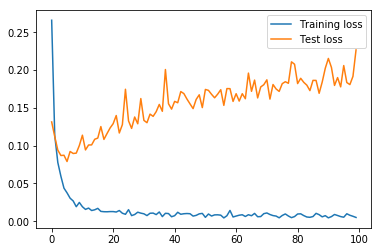

In [56]:
plt.plot(hist_4.history['loss'], label='Training loss')
plt.plot(hist_4.history['val_loss'], label='Test loss')
plt.legend()

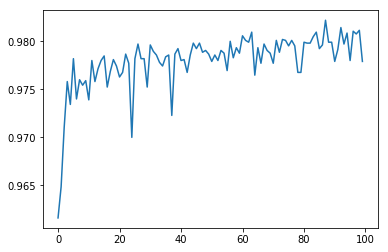

In [57]:
plt.plot(hist_4.history['val_acc'])

In [58]:
hist_4.history['val_acc'][-1]

0.9779047619047619

In [64]:
pred_list= model_4.predict_classes(X_test)

actual_list = []
for each in y_test:
    actual_list.append(np.argmax(each))

In [65]:
actual_list = pd.Series(actual_list, name='Actual')
pred_list = pd.Series(pred_list, name='Predicted')
keras4_confusion = pd.crosstab(actual_list, pred_list)
keras4_confusion

Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,1016,0,2,1,0,0,3,1,1,1
1,0,1134,4,0,0,0,1,1,6,0
2,0,4,1052,5,4,0,0,2,3,2
3,0,1,5,1132,0,5,0,1,4,3
4,2,1,4,0,976,1,6,5,1,28
5,0,1,0,26,0,857,5,1,3,5
6,5,1,2,0,1,2,995,0,4,0
7,0,2,5,1,2,1,0,1117,1,6
8,1,1,5,11,3,1,3,1,978,1


In [67]:
metrics.accuracy_score(pred_list, actual_list)

0.9779047619047619

## Model 5 Keras CNN

In [5]:
# Setting up our data and using keras to_categorical to get dummy variables for all y classes
y = data_train['label'].values
X = data_train.drop('label', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train/255
X_test = X_test/255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [8]:
model_5 = Sequential()

model_5.add(Convolution2D(filters=6,
                        kernel_size=3,
                        activation='relu',
                        input_shape=(28,28,1)))
model_5.add(MaxPooling2D(pool_size=(2,2)))
model_5.add(Convolution2D(filters=16,
                        kernel_size=3,
                        activation='relu'))
model_5.add(MaxPooling2D(pool_size=(2,2)))

model_5.add(Dropout(0.2))
model_5.add(Flatten())
model_5.add(Dense(128, activation='relu'))
model_5.add(Dropout(0.2))
model_5.add(Dense(10, activation='softmax'))

model_5.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
hist_5 = model_5.fit(X_train, y_train,
                    validation_data=(X_test,y_test),
                    batch_size=32, epochs=100, verbose=1)

Train on 31500 samples, validate on 10500 samples
Epoch 1/100
31500/31500 [==============================] - 15s 467us/step - loss: 0.3584 - acc: 0.8884 - val_loss: 0.1119 - val_acc: 0.9650
Epoch 2/100
31500/31500 [==============================] - 14s 442us/step - loss: 0.1378 - acc: 0.9569 - val_loss: 0.0848 - val_acc: 0.9741
Epoch 3/100
31500/31500 [==============================] - 14s 440us/step - loss: 0.1080 - acc: 0.9672 - val_loss: 0.0743 - val_acc: 0.9768
Epoch 4/100
31500/31500 [==============================] - 14s 447us/step - loss: 0.0908 - acc: 0.9707 - val_loss: 0.0524 - val_acc: 0.9843
Epoch 5/100
31500/31500 [==============================] - 14s 443us/step - loss: 0.0732 - acc: 0.9769 - val_loss: 0.0516 - val_acc: 0.9834
Epoch 6/100
31500/31500 [==============================] - 14s 441us/step - loss: 0.0661 - acc: 0.9785 - val_loss: 0.0475 - val_acc: 0.9863
Epoch 7/100
31500/31500 [==============================] - 14s 446us/step - loss: 0.0575 - acc: 0.9819 - val_l

Epoch 59/100
31500/31500 [==============================] - 14s 457us/step - loss: 0.0149 - acc: 0.9949 - val_loss: 0.0351 - val_acc: 0.9913
Epoch 60/100
31500/31500 [==============================] - 15s 475us/step - loss: 0.0153 - acc: 0.9948 - val_loss: 0.0346 - val_acc: 0.9927
Epoch 61/100
31500/31500 [==============================] - 15s 467us/step - loss: 0.0149 - acc: 0.9955 - val_loss: 0.0400 - val_acc: 0.9909
Epoch 62/100
31500/31500 [==============================] - 15s 470us/step - loss: 0.0117 - acc: 0.9958 - val_loss: 0.0405 - val_acc: 0.9909
Epoch 63/100
31500/31500 [==============================] - 14s 455us/step - loss: 0.0150 - acc: 0.9952 - val_loss: 0.0352 - val_acc: 0.9919
Epoch 64/100
31500/31500 [==============================] - 15s 463us/step - loss: 0.0130 - acc: 0.9955 - val_loss: 0.0382 - val_acc: 0.9906
Epoch 65/100
31500/31500 [==============================] - 15s 477us/step - loss: 0.0137 - acc: 0.9954 - val_loss: 0.0361 - val_acc: 0.9910
Epoch 66/100


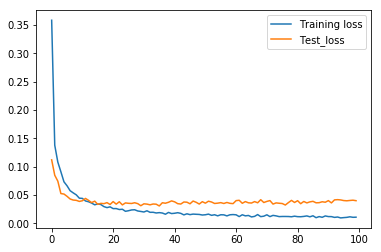

In [12]:
plt.plot(hist_5.history['loss'], label='Training loss')
plt.plot(hist_5.history['val_loss'], label='Test_loss')
plt.legend()

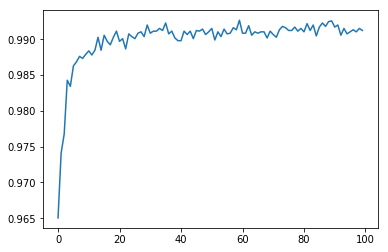

In [13]:
plt.plot(hist_5.history['val_acc'])

In [14]:
pred_list= model_5.predict_classes(X_test)

actual_list = []
for each in y_test:
    actual_list.append(np.argmax(each))

In [15]:
actual_list = pd.Series(actual_list, name='Actual')
pred_list = pd.Series(pred_list, name='Predicted')
keras5_confusion = pd.crosstab(actual_list, pred_list)
keras5_confusion

Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,1021,0,0,0,0,0,4,0,0,0
1,0,1142,1,0,1,0,1,0,1,0
2,0,1,1062,0,3,0,1,3,2,0
3,0,0,3,1138,0,1,0,5,3,1
4,1,1,1,0,1012,0,4,1,0,4
5,1,0,0,5,0,885,6,0,1,0
6,0,0,0,0,0,1,1006,0,3,0
7,1,4,2,0,2,0,0,1125,1,0
8,0,0,0,0,3,4,1,0,996,1


In [16]:
metrics.accuracy_score(pred_list, actual_list)

0.9912380952380953

### Model 5 keras cnn was the best model, there was some slight overfitting. But looking at the confusion matrix, it had the least false predictions, and the highest accuracy.